In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio

from rasterio.mask import mask
from shapely.geometry import mapping


# Demographics of Egypt

To support spatial inequality analytics for Egypt, the Data Lab used algorithmically generated data released by [Meta](https://dataforgood.facebook.com/dfg/docs/methodology-high-resolution-population-density-maps) to prepare baseline demographic data and [Relative Wealth Index](https://dataforgood.facebook.com/dfg/tools/relative-wealth-index) data from Meta to help identify spatial differences in the population's standard of living.


## Data

### High Resolution Population Density

In partnership with the Center for International Earth Science Information Network (CIESIN) at Columbia University, Meta uses state-of-the-art computer vision techniques to identify buildings from publicly accessible mapping services to create these population datasets. These maps are available at 30-meter resolution. These maps aren’t built using Facebook data and instead rely on applying machine vision AI to satellite imagery and census information. This data is publicly accessible on their [AWS Server](https://registry.opendata.aws/dataforgood-fb-hrsl/) and detailed documentation can be found [here](https://dataforgood.facebook.com/dfg/docs/methodology-high-resolution-population-density-maps). 

The Population Data is demographically disaggregated into the following categories
* Men
* Women
* Children under 5
* Elderly
* Women of Reproductive Age (15-49)
* Youth (15-24)
* Senior

### Relative Wealth Index

The Meta Relative Wealth Index predicts the relative standard of living within countries using privacy protecting connectivity data, satellite imagery, and other novel data sources. To calculate this index, Meta uses measurements of household wealth collected through *face-to-face surveys conducted by the United States Agency for International Development* with 1,457,315 unique households living in 66,819 villages in 56 different LMICs around the world. Following this, they use spatial markers to link villages to non-traditional data sources , including satellite imagery, cellular network data, topographic maps, and *privacy protecting connectivity data from Facebook*. They process the non-traditional data using deep learning and other computational algorithms, which convert the raw data to a set of quantitative features for each village. They use these features to train a supervised machine learning model that predicts the relative wealth of each populated 2.4km2 grid cell on the planet, even in regions where no ground truth data exists (Chi et. al., 2022).

The Relative Wealth Index is a number that compared the wealth within the country where negative RWI implies poorer areas and positive RWI implies richer areas. 

## Methodology and Implementation

The data extracted from Meta was then aggregated to different admin levels using the shapefiles available on [HdX](https://data.humdata.org/dataset/relative-wealth-index?). These datasets are made available on [SharePoint](https://worldbankgroup.sharepoint.com.mcas.ms/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=Yvwh8r&cid=fccdf23e%2D94d5%2D48bf%2Db75d%2D0af291138bde&FolderCTID=0x012000CFAB9FF0F938A64EBB297E7E16BDFCFD&id=%2Fteams%2FDevelopmentDataPartnershipCommunity%2DWBGroup%2FShared%20Documents%2FProjects%2FData%20Lab%2FEgypt%20Economic%20Monitor%2FData%2Frelative%5Fwealth%5Findex&viewid=80cdadb3%2D8bb3%2D47ae%2D8b18%2Dc1dd89c373c5). 

In [2]:
egypt_adm3 = gpd.read_file('../../data/shapefiles/egy_admbnda_adm3_capmas_20170421.shp')
egypt_adm2 = gpd.read_file('../../data/shapefiles/egy_admbnda_adm2_capmas_20170421/egy_admbnda_adm2_capmas_20170421.shp')
egypt_adm1 = gpd.read_file('../../data/shapefiles/egy_admbnda_adm1_capmas_20170421/egy_admbnda_adm1_capmas_20170421.shp')

In [3]:
from shapely.geometry import Point


hrsl = pd.read_csv('../../data/population/egy_general_2020_csv/egy_general_2020.csv')
geometry = [Point(xy) for xy in zip(hrsl.longitude, hrsl.latitude)]
gdf = gpd.GeoDataFrame(hrsl, crs="EPSG:4326", geometry=geometry)

In [15]:
# hrsl_egypt1 = egypt_adm1.sjoin(gdf)
# hrsl_egypt2 = egypt_adm2.sjoin(gdf)
hrsl_egypt3 = egypt_adm3.sjoin(gdf)

In [16]:
# hrsl_egypt1 = hrsl_egypt1.groupby(['ADM1_EN']).sum().reset_index()
# hrsl_egypt2 = hrsl_egypt2.groupby(['ADM1_EN', 'ADM2_EN', 'ADM2_PCODE']).sum().reset_index()
hrsl_egypt3 = hrsl_egypt3.groupby(['ADM1_EN', 'ADM2_EN', 'ADM3_PCODE', 'ADM2_PCODE']).sum().reset_index()

In [17]:
hrsl_egypt1 = egypt_adm1[['ADM1_EN', 'geometry']].merge(hrsl_egypt1[['ADM1_EN', 'egy_general_2020']], on = ['ADM1_EN'])
hrsl_egypt2 = egypt_adm2[['ADM1_EN', 'ADM2_EN', 'ADM2_PCODE'	,'geometry']].merge(hrsl_egypt2[['ADM1_EN','ADM2_EN', 'ADM2_PCODE'	,'egy_general_2020']], on = ['ADM1_EN', 'ADM2_EN', 'ADM2_PCODE'])
hrsl_egypt3 = egypt_adm3[['ADM1_EN', 'ADM2_EN', 'ADM3_PCODE','ADM2_PCODE','geometry']].merge(hrsl_egypt3[['ADM1_EN','ADM2_EN','ADM3_PCODE', 'ADM2_PCODE','egy_general_2020']], on = ['ADM1_EN', 'ADM2_EN','ADM2_PCODE', 'ADM3_PCODE'])

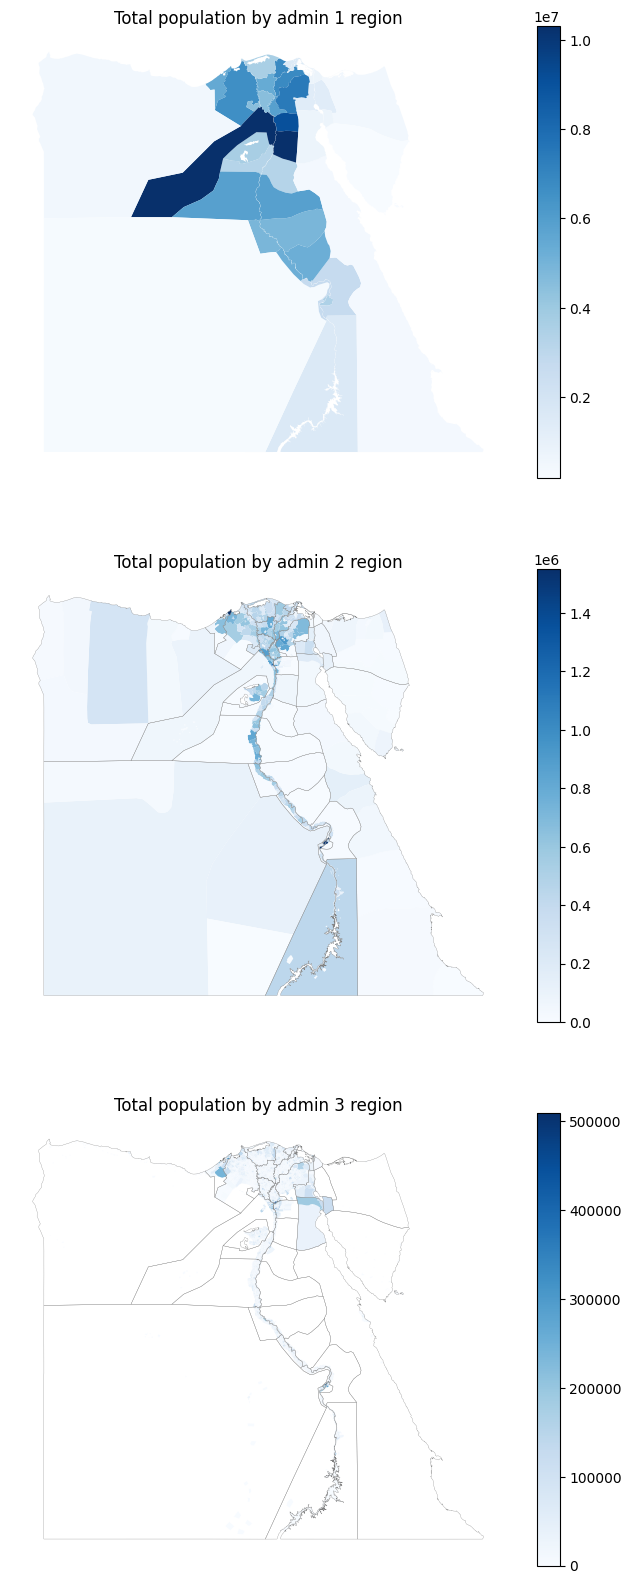

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,1, figsize=(8,20))
ax[0].axis('off')
hrsl_egypt1.plot(column='egy_general_2020', cmap='Blues', legend = True, ax=ax[0])
ax[0].set_title('Total population by admin 1 region', fontsize=12, ha='center')

leg = ax[0].get_legend()
if leg:
    leg.set_bbox_to_anchor((1, 0.5))
    leg.get_frame().set_linewidth(0.0)
    for text in leg.get_texts():
        text.set_fontsize(6)

ax[1].axis('off')
hrsl_egypt2.plot(column='egy_general_2020', cmap='Blues', legend = True, ax=ax[1])
ax[1].set_title('Total population by admin 2 region', fontsize=12, ha='center')
egypt_adm1.boundary.plot(ax=ax[1], color = 'gray', linewidth = 0.2)

# for i, cond in enumerate(hrsl_egypt2['max']):
#     if cond:
#         circle = patches.Circle((x[i], y[i]), radius=1, edgecolor='red', facecolor='none')
#         plt.gca().add_patch(circle)

ax[2].axis('off')
hrsl_egypt3.plot(column='egy_general_2020', cmap='Blues', legend = True, ax=ax[2])
ax[2].set_title('Total population by admin 3 region', fontsize=12, ha='center')
egypt_adm1.boundary.plot(ax=ax[2], color = 'gray', linewidth = 0.2)

subtitle_text = "Source: Population estimates from Meta's HRSL aggregated to admin regions from HdX"
#ax[0].text(-0.25, -0.05, subtitle_text, transform=ax.transAxes, fontsize=10, ha='left')

#### Top 5 Admin 1 Regions with Highest Population

In [24]:
hrsl_egypt1.sort_values(by='egy_general_2020', ascending = False)[['ADM1_EN', 'egy_general_2020']].head(5)

,ADM1_EN,egy_general_2020
10,Giza,1.032489e+07
5,Cairo,9.062930e+06
23,Sharkia,7.461139e+06
6,Dakahlia,6.826862e+06
3,Behera,6.604455e+06


#### Top 5 Admin 2 Regions with Highest Population

In [27]:
hrsl_egypt2.sort_values(by='egy_general_2020', ascending = False)[['ADM1_EN', 'ADM2_EN', 'ADM2_PCODE', 'egy_general_2020']].head(5)

,ADM1_EN,ADM2_EN,ADM2_PCODE,egy_general_2020
237,Alexandria,Muntazah,EG0201,1.550675e+06
202,Luxor,Luxor,EG2901,1.526273e+06
203,Luxor,Luxor,EG2902,1.513515e+06
340,Giza,Umraniyya,EG2118,1.225824e+06
174,Giza,Imbaba,EG2101,9.996363e+05


#### Top 5 Admin 3 Regions with Highest Population

In [30]:
hrsl_egypt3.sort_values(by='egy_general_2020', ascending = False)[['ADM1_EN', 'ADM2_EN', 'ADM2_PCODE','ADM3_PCODE','egy_general_2020']].head(5)

,ADM1_EN,ADM2_EN,ADM2_PCODE,ADM3_PCODE,egy_general_2020
2489,Kalyoubia,Shubra Al-Khayma 2,EG1407,EG140701,509457.455190
406,Cairo,Basatin,EG0135,EG013501,443118.097821
2524,Kalyoubia,Shubra Al-Khayma 1,EG1406,EG140602,441933.968251
3733,Kalyoubia,Khsos,EG1412,EG141201,400054.452690
1675,Luxor,Luxor,EG2901,EG290102,383640.934778


In [47]:
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

combined_polygons = list(egypt_adm1[egypt_adm1['ADM1_EN'].isin(list(hrsl_egypt1.sort_values(by='egy_general_2020', ascending = False)['ADM1_EN'].head(5)))]['geometry'])
all_polygons = list(egypt_adm1['geometry'])

# Calculate the area of all polygons
total_area = sum(polygon.area for polygon in all_polygons)

# Combine the specified polygons
combined_polygon = cascaded_union(combined_polygons)

# Calculate the area of the combined polygons
combined_area = combined_polygon.area

# Calculate the percentage of the area covered by the combined polygons
percentage_covered = (combined_area / total_area) * 100

print(f"Total area of Egypt: {total_area}")
print(f"Combined area of areas with the most population: {combined_area}")
print(f"Percentage covered: {percentage_covered:.2f}%")


Total area of Egypt: 90.14701025536662
Combined area of areas with the most population: 5.529366649690742
Percentage covered: 6.13%


C:\Users\sahit\AppData\Local\Temp\ipykernel_21688\578506915.py:11: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  combined_polygon = cascaded_union(combined_polygons)


### Observation on Population Spatial Distribution
We observe that the population is concentrated in just a few admin regions. Overall, Giza and Cairo have the highest populations, residing in 6.13% of the country's land area. 

In [60]:
rw = pd.read_csv('../../data/relative_wealth_index/egypt_relative_wealth_index.csv')
geometry = [Point(xy) for xy in zip(rw.longitude, rw.latitude)]
rw = gpd.GeoDataFrame(rw, crs="EPSG:4326", geometry=geometry)

Text(-0.25, -0.05, 'Source: Meta Data for Good')

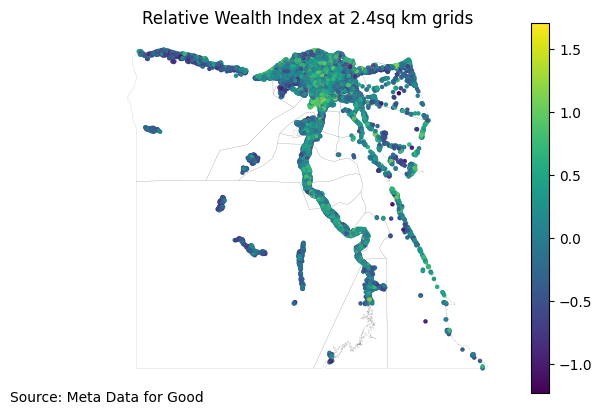

In [81]:
fig, ax = plt.subplots()
plt.axis('off')
rw.plot(column = 'rwi', legend = True, ax=ax, markersize=5)

plt.title('Relative Wealth Index at 2.4sq km grids', fontsize=12, ha='center')
egypt_adm1.boundary.plot(ax=ax, color = 'grey', linewidth = 0.1)

subtitle_text = "Source: Meta Data for Good"
ax.text(-0.25, -0.05, subtitle_text, transform=ax.transAxes, fontsize=10, ha='left')

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/848b312f-f47b-4185-840d-1253aa5de039/embed" frameborder="0" allowfullscreen></iframe>

```{figure} ../../docs/images/logo.png
---
height: 0px
---
The map above is interactive. By clicking the "eye" icons on the map, the user can explore either the locations of different points of interest or the locations of welath concentrations (or both, overlaid upon each other). 
```

### Observations on Relative Wealth Distribution 

- The wealthiest areas often appear adjacent to very poor areas, such as in the regions Beni Suef, Cairo, and Faiyum. 
- Wealtheir populations tend to be concentrated near bodies of water.  